In [2]:
%matplotlib inline
%matplotlib notebook
import nibabel as nib
from nibabel.processing import resample_to_output
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
from glob import glob
import re
import os

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.preprocessing import normalize
from sklearn.metrics import classification_report

seed = 42
np.random.seed(seed)  # for reproducibility

In [3]:
'''
    Checks whether a file exists and converts to local or cluster path if necessary
'''
def check_file_path(file_path):
    if os.path.isfile(file_path):
        return file_path
    else:
        to_cluster_path = "/Dedicated/jmichaelson-" + file_path[1:]
        to_local_path = "/" + file_path[22:]

        if os.path.isfile(to_cluster_path):
            return to_cluster_path
        elif os.path.isfile(to_local_path):
            return to_local_path
        else:
            print("No valid file path")
            return "NOPE"

## The Labels


In [5]:
# zero-pad some of the entries so they match the filenames
label_file = '/Dedicated/jmichaelson-wdata/mcrichter/HackUiowa2018/DATA/2018_IA_Hackathon/Factor_Data/comprehension_ability_crystalized_intelligence_with_the_variance_of_g_removed.xlsx'
df = pd.read_excel(check_file_path(label_file),
                   converters={'ID': lambda x: str(x).zfill(4)},
          )
# make the ID the index in the pandas dataframe
df.set_index('ID', inplace=True)

In [48]:
label_df = pd.read_csv("/Dedicated/jmichaelson-sdata/comppsych/lesion/phenotype_405.csv")
label_df

,ID,Gc_bi_all_subs_405,Gc_all_subs_405,Gl_all_subs_405,Gl_bi_all_subs_405,Gs_all_subs_405,Gs_bi_all_subs_405,Gv_all_subs_405,Gv_bi_all_subs_405,Gwm_all_subs_405,Gwm_bi_all_subs_405,g_bi_all_subs_405,g_hi_all_subs_405
0,194,0.280165,-0.425845,-0.972046,-0.924240,-0.818462,-0.596712,-0.013080,0.928886,-0.783726,-0.516991,-0.672247,-0.698339
1,297,0.390203,0.285491,-1.999740,-2.520697,0.215225,0.323129,0.230828,-0.075928,0.449694,0.662667,0.284658,0.285341
2,318,0.555099,2.083843,0.704475,-0.277461,1.674966,0.004435,2.099044,0.501042,1.981132,-0.005991,2.212497,2.098086
3,376,-0.412211,-1.317183,-0.308457,0.498059,-1.299558,0.072503,-1.722894,-0.866534,-1.451246,-0.069463,-1.538743,-1.526178
4,414,-1.209015,-1.240517,-0.479600,-0.556820,-0.597491,-0.169685,-0.422785,0.204322,-0.486857,0.144966,-0.661666,-0.708529
5,468,0.943766,1.100817,-0.582900,-0.895843,0.291387,-0.544236,1.045307,0.866347,0.738626,-0.079611,0.728580,0.782374
6,500,-0.377269,0.624045,-0.934794,-1.674852,0.245556,-0.098610,-0.045300,-1.021389,1.323458,1.314497,0.974868,0.847392
7,513,-0.734567,-2.081386,-2.516591,-1.699193,-1.078296,0.480664,-0.995585,0.209477,-1.529889,-0.153968,-1.828077,-1.711982
8,571,-1.421442,-0.559533,0.834696,0.800926,1.549833,1.041738,0.698749,0.498936,0.078731,-0.127824,0.345916,0.326303
9,615,0.200815,-0.553417,-0.323284,-0.474592,-0.930682,-0.845479,-0.436661,0.477143,-0.750650,0.151976,-0.777013,-0.754159


## Data vectorized in a Dataframe

In [6]:
data = []
labels = []
lesion_masks = glob('/Dedicated/jmichaelson-wdata/mcrichter/HackUiowa2018/DATA/2018_IA_Hackathon/Factor_Data/All_subs_405_Lesion_Masks/*.nii.gz')
for les_file in lesion_masks:
    match = re.match(r'.*/([0-9]{4}).nii.gz', les_file)
    sub_id = match.groups()[0]
    labels.append(df.loc[sub_id]['Score'])
    les_img = nib.load(les_file)
    les_data = les_img.get_data()
    data.append(les_data)
#     les_data_1d = les_data.reshape(np.prod(les_data.shape))
#     data_collector[sub_id] = les_data #les_data_1d

[array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ...,

In [18]:
data_array = np.array(data, dtype="float")
labels_array = np.array(labels, dtype="float")
print "Data shape: ", data_array.shape
print "Label shape: ", labels_array.shape

Data shape:  (405, 182, 218, 182)
Label shape:  (405,)


In [5]:
data_array_flattened = data_array.reshape((data_array.shape[0], -1))
print "Flattened data shape: ", data_array_flattened.shape

Flattened data shape:  (405, 7221032)


## Saving the data. Only run if something above was changed (takes a while)

In [19]:
np.save("/Dedicated/jmichaelson-wdata/mcrichter/HackUiowa2018/DATA/All_subs_405_LM_np_array", data_array)

In [20]:
np.save("/Dedicated/jmichaelson-wdata/mcrichter/HackUiowa2018/DATA/All_subs_405_labels", labels_array)

In [22]:
np.save("/Dedicated/jmichaelson-wdata/mcrichter/HackUiowa2018/DATA/All_subs_405_LM_np_array_flattened", data_array_flattened)

## Remove all columns that are 0

In [6]:
data_array_flattened_reduced = data_array_flattened[:,~np.all(data_array_flattened == 0, axis=0)]
print "Reduced dimensionality by ", data_array_flattened.shape[1] - data_array_flattened_reduced.shape[1]
print "Now contains ", data_array_flattened_reduced.shape[1], " features"

Reduced dimensionality by  5580174
Now contains  1640858  features


In [7]:
np.save("/Dedicated/jmichaelson-wdata/mcrichter/HackUiowa2018/DATA/All_subs_405_LM_np_array_flattened_reduced", data_array_flattened_reduced)

## Load data for CNN

In [4]:
data_array = np.load("/Dedicated/jmichaelson-wdata/mcrichter/HackUiowa2018/DATA/All_subs_405_LM_np_array.npy")
labels_array = np.load("/Dedicated/jmichaelson-wdata/mcrichter/HackUiowa2018/DATA/All_subs_405_labels.npy")

## Load data for NN

In [ ]:
data_array_flattened = np.load("/Dedicated/jmichaelson-wdata/mcrichter/HackUiowa2018/DATA/All_subs_405_LM_np_array_flattened")
labels_array = np.load("/Dedicated/jmichaelson-wdata/mcrichter/HackUiowa2018/DATA/All_subs_405_labels.npy")
data_array_flattened_reduced = np.load("/Dedicated/jmichaelson-wdata/mcrichter/HackUiowa2018/DATA/All_subs_405_LM_np_array_flattened_reduced")

## Visualizing the data

<IPython.core.display.Javascript object>


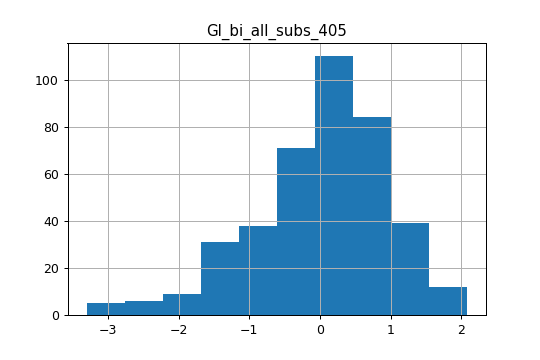

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2ac771244190>]],
      dtype=object)

In [60]:
label_df.hist(column ="Gl_bi_all_subs_405")

<IPython.core.display.Javascript object>


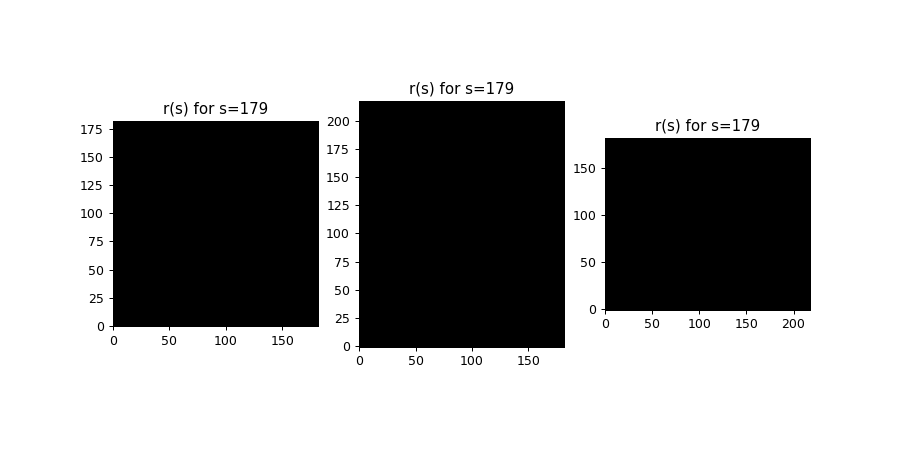

In [40]:
fig = plt.figure("Lesion mask", figsize=(10, 5))
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)
# ax2 = fig.add_subplot(1, 2, 2, projection='3d')

image = data_array[0,:,:,:]
for s in range(180):
    ax1.cla()
    ax1.set_title("r(s) for s={}".format(s))
    ax1.imshow(image[:,s,:], cmap="gray", origin="lower")

    ax2.cla()
    ax2.set_title("r(s) for s={}".format(s))
    ax2.imshow(image[s,:,:], cmap="gray", origin="lower")
    
    ax3.cla()
    ax3.set_title("r(s) for s={}".format(s))
    ax3.imshow(image[:,:,s], cmap="gray", origin="lower")
#     ax2.cla()
#     ax2.set_title("theta(s) for s={}".format(s))
#     ax2.set_zlim3d(0, 1)
#     ax2.plot([u[0]], [u[1]], zs=[0], marker='o', color='orange', markersize=5)
#     ax2.plot_wireframe(v[:, :, 0], v[:, :, 1], theta(u, v, s, S))

    fig.canvas.draw()

In [41]:
pos = np.where(image==1)

<IPython.core.display.Javascript object>


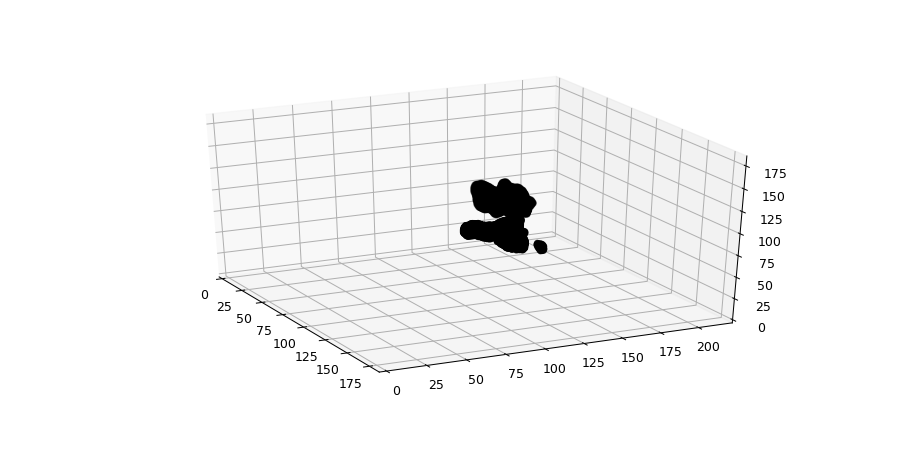

In [62]:
fig = plt.figure("Lesion mask 3D", figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection='3d')

ax.scatter(pos[0], pos[1], pos[2], c='black')
ax.set_xlim3d(0, 182)
ax.set_ylim3d(0, 218)
ax.set_zlim3d(0, 182)
fig.canvas.draw()